In [21]:
import pandas as pd
import numpy as np

data = pd.read_csv("/Users/igyuseog/Desktop/data09/funda_train.csv")
submit = pd.read_csv("/Users/igyuseog/Desktop/data09/submission.csv")

# step1: EDA
- 데이터를 확인하면서, 결측치를 제거하자

In [24]:
# 각 column별 null값을 확인해보자.
col_name = data.columns.tolist()
for col in col_name:
    print(col, data[col].isnull().sum())   # region의 결측치가 너무 많으므로 drop해준다.
# 수행 결과    
data = data.drop(["region"], axis = 1)

store_id 0
card_id 0
card_company 0
transacted_date 0
transacted_time 0
installment_term 0
region 2042766
type_of_business 3952609
amount 0


In [39]:
data["store_id"].value_counts()

#store의 개수가 총 1967개이고, 데이터의 개수가 다르다.
#이럴때는 어떻게 하면좋을까?
#우리가 원하는 건 상점별 매출이기 때문에, 각각 다르게 만들어줘야 할것 같다.

1330    9518
1196    9471
1171    9391
710     9347
826     9328
        ... 
1974     429
1240     426
795      231
2119     112
1063      72
Name: store_id, Length: 1967, dtype: int64

# step2: 모델링
- 이전에 Keras에서 주가예측 모델을 만든적이 있는데, 그것을 바탕으로 해당 모델을 만들어보고 싶다
- 따라서 input데이터는 2년치의 amount이고, 아웃풋은 3개월간의 총 매출

In [90]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Activation
import datetime
from sklearn.model_selection import train_test_split

In [110]:
store = set(data["store_id"].values)

In [91]:
train = data[data["store_id"] == 1330]["amount"].values
print(data[data["store_id"] == 1330]["amount"].head())

4050735     6857.142857
4050736     6714.285714
4050737    14285.714286
4050738     7142.857143
4050739     8285.714286
Name: amount, dtype: float64


In [92]:
seq_len = 30 # 1 ~ 30을 보고 31을 맞추자.
seqence_length = seq_len + 1

result = []
for index in range(len(train) - seqence_length):
    result.append(train[index: index + seqence_length]) #30개씩저장

In [93]:
#정규화
# 9487 * 31 만큼의 데이터가 존재

target = 0
normal_data = []
for window in result:
    target = window[0]
    normal_data.append((window / window[0]) -1)
result = np.array(normal_data)


In [94]:
target

285.7142857142857

In [72]:
#train과 test set을 나눠서 해보자.
X = result[:,:-1]
y = result[:,-1]

#shuffle을 안해도 됌
x_train, x_test, y_train, y_test = train_test_split(X,y, shuffle = False, test_size = 0.1)

# shape을 3차원으로!
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [73]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8538, 30, 1) (8538,)
(949, 30, 1) (949,)


# Build a model

In [74]:
model = Sequential()

# 첫번째
model.add(LSTM(30,
               return_sequences = True,
               input_shape = (30,1)))
# 두번째
model.add(LSTM(64,
              return_sequences = False))
# 아웃풋
model.add(Dense(1, activation = "linear"))

# 컴파일
model.compile(loss = "mse", optimizer = "rmsprop")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [75]:
# 학습진행
model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size = 10,
         epochs = 5)


Epoch 1/5
854/854 [==============================] - 20s 20ms/step - loss: 0.7999 - val_loss: 0.9967
Epoch 2/5
854/854 [==============================] - 15s 18ms/step - loss: 0.6941 - val_loss: 1.0031
Epoch 3/5
854/854 [==============================] - 15s 18ms/step - loss: 0.7345 - val_loss: 1.1910
Epoch 4/5
854/854 [==============================] - 16s 19ms/step - loss: 0.7785 - val_loss: 1.0023
Epoch 5/5
854/854 [==============================] - 15s 18ms/step - loss: 0.7571 - val_loss: 0.9388


In [76]:
pred = model.predict(x_test)

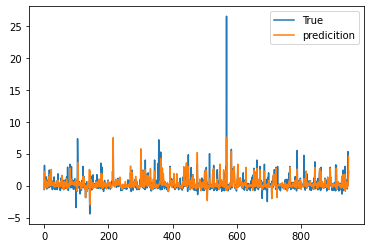

In [78]:
import matplotlib.pyplot as plt
plt.plot(y_test, label = "True")
plt.plot(pred, label = "predicition")
plt.legend()
plt.show()

In [84]:
# 맨마지막을 가지고 3번을 더해보자.
graph = []
temp = x_test[-1].reshape(1,-1,1)
cnt = 0

while cnt < 3:
    answer = model.predict(temp)
    graph.append(float(answer.squeeze()))
    temp2 = temp.squeeze(axis = 0)
    temp = np.concatenate([temp2,answer], axis = 0)
    temp = temp.reshape(1,-1,1)
    
    cnt += 1
    

In [96]:
predict = list(map(lambda x: (x+1)*target, graph))

In [111]:
a = []
a.append(sum(predict))

In [112]:
a

[4660.3792735508505]